<a href="https://colab.research.google.com/github/aparajitaks/Drug_Response_ML/blob/main/03_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

clean_path = "/content/drive/MyDrive/Drug-Response-ML/data/processed/feature_data.csv"
df = pd.read_csv(clean_path)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,uniqueID,drugName,condition,review,rating,date,usefulCount,response_category
0,206461,valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,95260,guanfacine,adhd,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2
2,92703,lybrel,birth control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1
3,138000,ortho evra,birth control,"""This is my first time using any form of birth...",8,3-Nov-15,10,2
4,35696,buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2


Define Features & Target

In [4]:
features=['drugName','condition','usefulCount']
target='response_category'

X = df[features]
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (215063, 3)
y shape: (215063,)


Encode Categorical Data

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

cat_features = ["drugName", "condition"]
num_features = ["usefulCount"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("num", "passthrough", num_features)
])


Train-Test Split


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Baseline Model – Logistic Regression

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.43      0.56      0.49     10715
           1       0.20      0.35      0.25      6346
           2       0.81      0.56      0.66     25952

    accuracy                           0.53     43013
   macro avg       0.48      0.49      0.47     43013
weighted avg       0.62      0.53      0.56     43013



In [8]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svm_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearSVC(
        class_weight="balanced",
        max_iter=5000
    ))
])

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))




              precision    recall  f1-score   support

           0       0.44      0.56      0.49     10715
           1       0.24      0.12      0.16      6346
           2       0.74      0.74      0.74     25952

    accuracy                           0.60     43013
   macro avg       0.47      0.47      0.46     43013
weighted avg       0.59      0.60      0.59     43013



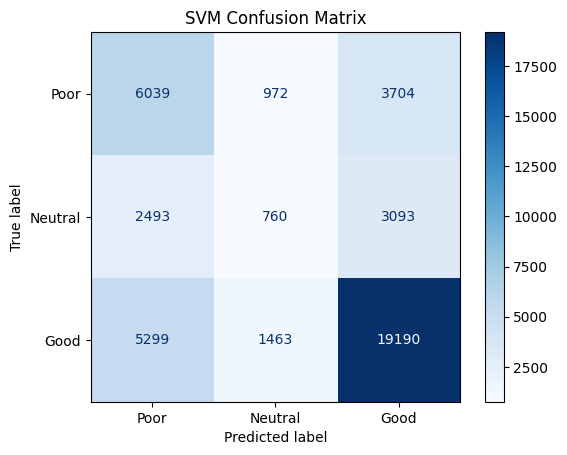

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Poor", "Neutral", "Good"])

disp.plot(cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.show()


In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_cv_scores = cross_val_score(
    svm_model,
    X,
    y,
    cv=cv,
    scoring="f1_macro"
)

print("SVM CV F1-macro scores:", svm_cv_scores)
print("Mean F1-macro:", svm_cv_scores.mean())


SVM CV F1-macro scores: [0.46328056 0.46066889 0.46261578 0.45974426 0.46131923]
Mean F1-macro: 0.4615257450120794


In [11]:
from sklearn.linear_model import LogisticRegression

logreg_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)

print("Logistic Regression Report")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Report
              precision    recall  f1-score   support

           0       0.43      0.56      0.49     10715
           1       0.20      0.35      0.25      6346
           2       0.81      0.56      0.66     25952

    accuracy                           0.53     43013
   macro avg       0.48      0.49      0.47     43013
weighted avg       0.62      0.53      0.56     43013



In [12]:
logreg_cv_scores = cross_val_score(
    logreg_model,
    X,
    y,
    cv=cv,
    scoring="f1_macro"
)

print("LogReg CV F1-macro scores:", logreg_cv_scores)
print("Mean F1-macro:", logreg_cv_scores.mean())


LogReg CV F1-macro scores: [0.46887662 0.46661674 0.47043872 0.46191794 0.46784783]
Mean F1-macro: 0.4671395689090604


In [13]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["SVM", "Logistic Regression"],
    "CV F1-macro": [svm_cv_scores.mean(), logreg_cv_scores.mean()]
})

results


,Model,CV F1-macro
0,SVM,0.461526
1,Logistic Regression,0.467140


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__C": [0.1, 1, 10]
}

grid = GridSearchCV(
    svm_model,
    param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best C:", grid.best_params_)
print("Best CV F1-macro:", grid.best_score_)


Best C: {'model__C': 10}
Best CV F1-macro: 0.4613935404697661


In [15]:
import numpy as np
import pandas as pd

model = logreg_model.named_steps["model"]

# Get feature names directly from TF-IDF
feature_names = logreg_model.named_steps["preprocess"].get_feature_names_out()

coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    "word": feature_names,
    "coefficient": coefficients
})

coef_df.head()


,word,coefficient
0,cat__drugName_a + d cracked skin relief,-0.140615
1,cat__drugName_a / b otic,-0.186924
2,cat__drugName_abacavir / dolutegravir / lamivu...,-0.162092
3,cat__drugName_abacavir / lamivudine,-0.054449
4,cat__drugName_abacavir / lamivudine / zidovudine,-0.057623


In [16]:
 coef_df.sort_values("coefficient", ascending=False).head(10)
coef_df.sort_values("coefficient").head(10)


,word,coefficient
2951,cat__drugName_subutex,-1.643569
1514,cat__drugName_hycodan,-1.566547
666,cat__drugName_chlorpheniramine / hydrocodone,-1.547567
4023,cat__condition_mitral valve prolapse,-1.531176
2603,cat__drugName_propafenone,-1.485717
1339,cat__drugName_fluoxetine / olanzapine,-1.412807
3998,cat__condition_mance anxiety,-1.398497
434,cat__drugName_benzoyl peroxide / erythromycin,-1.391117
2864,cat__drugName_simcor,-1.368407
2359,cat__drugName_oxazepam,-1.362075


In [17]:
!pip install shap


In [18]:
X_train_transformed = logreg_model.named_steps["preprocess"].transform(X_train)


In [19]:
import numpy as np

sample_size = 300  # safe for Colab
idx = np.random.choice(
    X_train_transformed.shape[0],
    sample_size,
    replace=False
)

X_shap = X_train_transformed[idx]


In [20]:
lr_model = logreg_model.named_steps["model"]


In [21]:
import shap

explainer = shap.LinearExplainer(
    lr_model,
    X_shap,
    feature_names=feature_names
)


In [22]:
shap_values = explainer(X_shap)


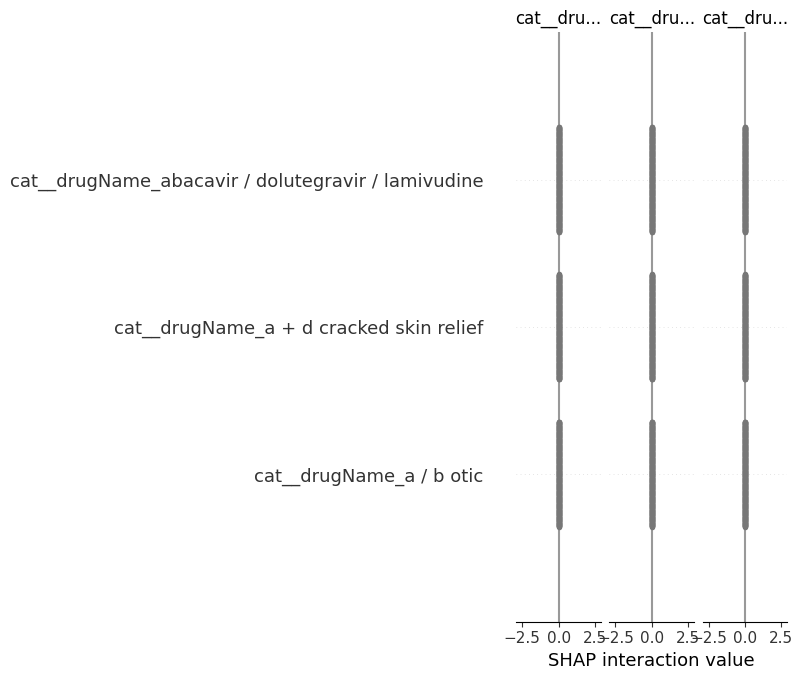

In [23]:
shap.summary_plot(
    shap_values.values,
    X_shap,
    feature_names=feature_names
)
